In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import holidays
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GroupKFold,TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
train_df=pd.read_csv('data/train.csv')
test_df=pd.read_csv('data/test.csv')

In [3]:
train_df.head(2)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0


In [4]:
test_df.head(2)

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
train_df['date']=pd.to_datetime(train_df['date'])
test_df['date']=pd.to_datetime(test_df['date'])

In [8]:
train_df['year']=train_df['date'].dt.year-2010
test_df['year']=test_df['date'].dt.year-2010

train_df['month']=train_df['date'].dt.month/31.0
test_df['month']=test_df['date'].dt.month/31.0

train_df['day']=train_df['date'].dt.day/365.0
test_df['day']=test_df['date'].dt.day/365.0

train_df['weekday']=train_df['date'].dt.weekday
test_df['weekday']=test_df['date'].dt.weekday

train_df['day_of_week']=train_df['date'].dt.day_of_week
test_df['day_of_week']=test_df['date'].dt.day_of_week

train_df['day_sin']=np.sin(train_df['day']*np.pi*2)
test_df['day_sin']=np.sin(test_df['day']*np.pi*2)

train_df['day_cos']=np.cos(train_df['day']*np.pi*2)
test_df['day_cos']=np.cos(test_df['day']*np.pi*2)

train_df['month_sin']=np.sin(train_df['month']*np.pi*2)
test_df['month_sin']=np.sin(test_df['month']*np.pi*2)

train_df['month_cos']=np.cos(train_df['month']*np.pi*2)
test_df['month_cos']=np.cos(test_df['month']*np.pi*2)

In [9]:
object_cols=train_df.select_dtypes(include='object').columns
object_cols

Index(['country', 'store', 'product'], dtype='object')

In [10]:

le=LabelEncoder()
for col in object_cols: 
    train_df[col]=le.fit_transform(train_df[col])
    test_df[col]=le.transform(test_df[col])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           230130 non-null  int64         
 1   date         230130 non-null  datetime64[ns]
 2   country      230130 non-null  int32         
 3   store        230130 non-null  int32         
 4   product      230130 non-null  int32         
 5   num_sold     221259 non-null  float64       
 6   year         230130 non-null  int32         
 7   month        230130 non-null  float64       
 8   day          230130 non-null  float64       
 9   weekday      230130 non-null  int32         
 10  day_of_week  230130 non-null  int32         
 11  day_sin      230130 non-null  float64       
 12  day_cos      230130 non-null  float64       
 13  month_sin    230130 non-null  float64       
 14  month_cos    230130 non-null  float64       
dtypes: datetime64[ns](1), float64(7), 

<Axes: >

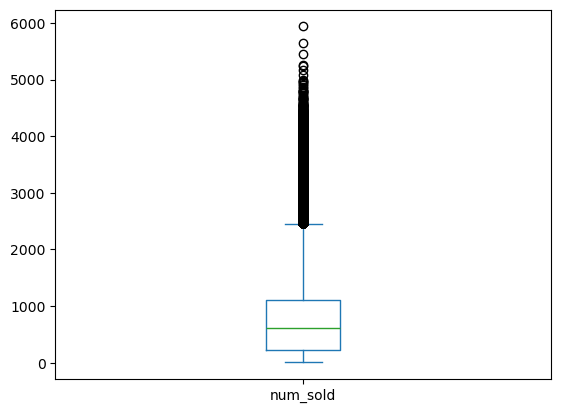

In [12]:
train_df[train_df['num_sold'].notnull()]['num_sold'].plot(kind='box')

In [13]:
train_df=train_df.dropna()

In [14]:
train_df.corr()['num_sold'].sort_values(ascending=False)

num_sold       1.000000
store          0.239883
country        0.129113
weekday        0.069613
day_of_week    0.069613
month_cos      0.006790
product        0.004255
day            0.001137
day_sin        0.000936
day_cos       -0.003392
month         -0.006255
month_sin     -0.008133
year          -0.040462
id            -0.040866
date          -0.040936
Name: num_sold, dtype: float64

In [15]:
train_df=train_df.drop('date',axis=1)
test_df=test_df.drop('date',axis=1)

In [16]:
train_df['num_sold']=np.log1p(train_df['num_sold'])

<Axes: ylabel='Density'>

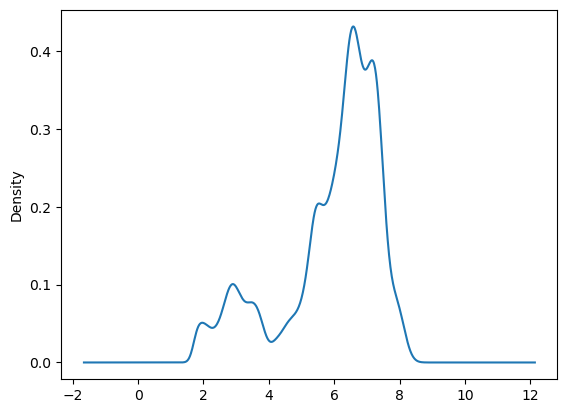

In [17]:
train_df['num_sold'].plot(kind='kde')

In [18]:
X=train_df.drop('num_sold',axis=1)
y=train_df['num_sold']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(X_train)
scaled_X_test=scaler.transform(X_test)


In [21]:
lgbm=LGBMRegressor()
lgbm.fit(scaled_X_train,y_train)
lgbm_preds=lgbm.predict(scaled_X_test)
mean_absolute_percentage_error(np.expm1(y_test),np.expm1(lgbm_preds))

c:\Users\gavat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gavat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\gavat\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gavat\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\gavat\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 199133, number of used features: 13
[LightGBM] [Info] Start training from score 5.937097


0.053491407919352876

In [22]:
train_preds=lgbm.predict(scaled_X_train)

In [23]:
scaled_test_df=scaler.transform(test_df)

In [24]:
test_df_preds=lgbm.predict(scaled_test_df)

In [25]:
test_df_preds

array([4.84725905, 6.70649141, 6.52727056, ..., 7.58709781, 7.04184249,
       7.12811497])

In [26]:
final_df=pd.DataFrame()
final_df['id']=test_df['id']
final_df['num_sold']=np.expm1(test_df_preds)

In [27]:
final_df

,id,num_sold
0,230130,126.390740
1,230131,816.696641
2,230132,682.530010
3,230133,362.027065
4,230134,448.839696
...,...,...
98545,328675,372.271300
98546,328676,2321.262164
98547,328677,1971.580387
98548,328678,1142.492538


In [28]:
final_df.to_csv('submissions/tt_split_lgbm.csv',index=False)

In [29]:
best_params={
      'n_estimators': 4404,
    'learning_rate': 0.04424966600955587,
    'max_depth': 14,
    'reg_alpha': 0.05907466099960179,
    'reg_lambda': 0.05893951723595668,
    'min_child_samples': 16,
    'colsample_bytree': 0.4790420053903868,
    'subsample': 0.9750274872564602,
    'objective': 'regression',
    'metric': 'mape',
    'device': 'gpu',  # Use GPU for faster computation
    'n_jobs': -1      # Use all available CPU cores
}
# lgbm=LGBMRegressor(**best_params)
# lgbm.fit(scaled_X_train,y_train)
# preds=lgbm.predict(scaled_X_test)
# mean_absolute_percentage_error(y_test,preds)

In [30]:
# test_df_preds=lgbm.predict(scaled_test_df)

In [31]:
# final_df=pd.DataFrame()
# final_df['id']=test_df['id']
# final_df['num_sold']=np.expm1(test_df_preds)

In [32]:
# final_df.to_csv('submissions/lgbm_params_2.csv')

In [33]:
group_kfold=GroupKFold(7)
group=train_df['year']
errors=[]
all_idx=[]
for i,(train_idx,test_idx) in enumerate(group_kfold.split(X,y,group)):
    X_train,X_test=X.iloc[train_idx],X.iloc[test_idx]
    y_train,y_test=y.iloc[train_idx],y.iloc[test_idx]

    scaler=StandardScaler()
    scaled_X_train=scaler.fit_transform(X_train)
    scaled_X_test=scaler.transform(X_test)

    lgbm_gk=LGBMRegressor(**best_params)
    lgbm_gk.fit(scaled_X_train,y_train)
    pred=lgbm_gk.predict(scaled_X_test)
    mape=mean_absolute_percentage_error(y_test,pred)
    errors.append(mape)
    all_idx.append((train_idx,test_idx))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 189436, number of used features: 13
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (2.89 MB) transferred to GPU in 0.005384 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 5.934615
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 189492, number of used features: 13
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[Light

In [34]:
errors

[0.014069697291898858,
 0.012223990101653984,
 0.010811928764093644,
 0.019762529951552563,
 0.020934853920629985,
 0.014471441511747726,
 0.025901920741760627]

In [47]:
error_min_idx=-2
best_train_idx_gk,best_test_idx_gk=all_idx[error_min_idx]

In [48]:
X_train_gk,X_test_gk=X.iloc[best_train_idx_gk],X.iloc[best_test_idx_gk]
y_train_gk,y_test_gk=y.iloc[best_train_idx_gk],y.iloc[best_test_idx_gk]

In [49]:
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(X_train_gk)
scaled_X_test=scaler.transform(X_test_gk)

In [50]:
lgbm_gk=LGBMRegressor(**best_params)
lgbm_gk.fit(scaled_X_train,y_train_gk)
test_df_preds=lgbm_gk.predict(scaled_test_df)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 189814, number of used features: 13
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (2.90 MB) transferred to GPU in 0.004036 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 5.923564


In [51]:
final_df=pd.DataFrame({
    'id':test_df['id'],
    'num_sold':np.expm1(test_df_preds)
})

In [52]:
final_df.to_csv('submissions/lgbm_gk_best_6.csv',index=False)

In [44]:
tscv=TimeSeriesSplit(7)

In [45]:
errors_ts=[]
all_idx_ts=[]
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]

    lgbm_normal=LGBMRegressor(**best_params)
    scaler=StandardScaler()

    scaled_X_train=scaler.fit_transform(X_train)
    scaled_X_test=scaler.transform(X_test)

    lgbm_normal.fit(scaled_X_train,y_train)
    lgbm_normal_preds=lgbm_normal.predict(scaled_X_test)

    mape=mean_absolute_percentage_error(y_test,lgbm_normal_preds)
    errors_ts.append(mape)
    all_idx_ts.append((train_index,test_index))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 27660, number of used features: 12
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (0.32 MB) transferred to GPU in 0.002029 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 5.902303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [69]:
best_idx=[]
error_min_idx_ts=0
best_train_idx_ts,best_test_idx_ts=all_idx_ts[error_min_idx_ts]

In [70]:
errors_ts

[0.020644934351643725,
 0.016871753690510055,
 0.011316246714166025,
 0.011653591234373265,
 0.014497350499630248,
 0.01166247049018802,
 0.011147210806101076]

In [71]:
X_train_ts,y_train_ts=X.iloc[best_train_idx_ts],y.iloc[best_train_idx_ts]
X_test_ts,y_test_ts=X.iloc[best_test_idx_ts],y.iloc[best_test_idx_ts]

In [72]:
scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(X_train_ts)
scaled_X_test=scaler.transform(X_test_ts)

In [73]:
lgbm_ts=LGBMRegressor(**best_params)
lgbm_ts.fit(scaled_X_train,y_train_ts)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 27660, number of used features: 12
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (0.32 MB) transferred to GPU in 0.032377 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 5.902303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMRegressor(colsample_bytree=0.4790420053903868, device='gpu',
              learning_rate=0.04424966600955587, max_depth=14, metric='mape',
              min_child_samples=16, n_estimators=4404, n_jobs=-1,
              objective='regression', reg_alpha=0.05907466099960179,
              reg_lambda=0.05893951723595668, subsample=0.9750274872564602)

In [74]:
test_preds_ts=np.expm1(lgbm_ts.predict(scaled_test_df))
final_df=pd.DataFrame()
final_df['id']=test_df['id']
final_df['num_sold']=test_preds_ts
final_df.to_csv('submissions/lgbm_ts_best_2.csv',index=False)